<a href="https://colab.research.google.com/github/sabbirarif/Thesis_Project/blob/main/Brinjal_Disease_Detection_Using_Deep_Learning_main_file_(1).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Dependencies

In [ ]:
import os
import sys
import cv2
import numpy as np
import matplotlib.pyplot as plt
from textwrap import wrap

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras import datasets, layers, models

from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split

from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.optimizers import SGD
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator


In [ ]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS=3
EPOCHS=25

## Importing Dataset

In [ ]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    "Augmented Data",
    shuffle=True,
    image_size = (IMAGE_SIZE,IMAGE_SIZE),
    batch_size = BATCH_SIZE
)

Found 1187 files belonging to 4 classes.


In [ ]:
class_names=dataset.class_names
class_names

['Brinjal Fruit Cracking',
 'Brinjal fruit and shoot borer',
 'Healthy Brinjal',
 'Phomopsis blight']

In [ ]:
d1=tf.keras.preprocessing.image_dataset_from_directory(
    "Brinjal Fruit Cracking",
    batch_size = 1
)
d2=tf.keras.preprocessing.image_dataset_from_directory(
    "Brinjal fruit and shoot borer",
    batch_size = 1
)
d3=tf.keras.preprocessing.image_dataset_from_directory(
    "Healthy Brinjal",
    batch_size = 1
)
d4=tf.keras.preprocessing.image_dataset_from_directory(
    "Phomopsis blight",
    batch_size = 1
)

Found 112 files belonging to 1 classes.
Found 531 files belonging to 1 classes.
Found 273 files belonging to 1 classes.
Found 271 files belonging to 1 classes.


In [ ]:
len(d1)

112

([<matplotlib.patches.Wedge at 0x234a83f4ac0>,
 [Text(-0.32131497664204167, 1.052025040474572, 'Brinjal Fruit Cracking'),
  Text(-1.0010345384432071, -0.4559932596473282, 'Brinjal fruit and shoot borer'),
  Text(0.9163314365148466, -0.608552954519685, 'Healthy Brinjal'),
  Text(0.7230434003407038, 0.8289802417571561, 'Phomopsis blight')],
 [Text(-0.17526271453202272, 0.5738318402588573, '9%'),
  Text(-0.5460188391508402, -0.24872359617126988, '45%'),
  Text(0.49981714718991627, -0.3319379751925554, '23%'),
  Text(0.39438730927674753, 0.45217104095844873, '23%')])

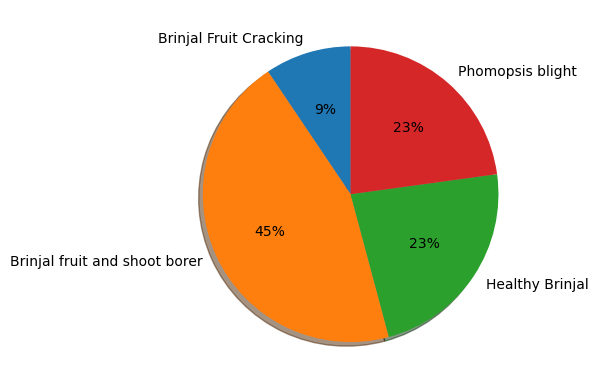

In [ ]:
name = class_names
data = [len(d1), len(d2), len(d3), len(d4)]
plt.pie(data, labels=name, autopct='%0.f%%', shadow=True, startangle=90)

In [ ]:
len(dataset)

38

In [ ]:
for image_batch, labels_batch in dataset.take(1):
    print(image_batch.shape)
    print(labels_batch.numpy())

(32, 256, 256, 3)
[1 1 3 1 1 1 1 2 3 1 2 1 2 0 1 2 2 1 1 1 1 2 1 3 1 2 3 0 1 3 2 1]


## Visualizing Dataset

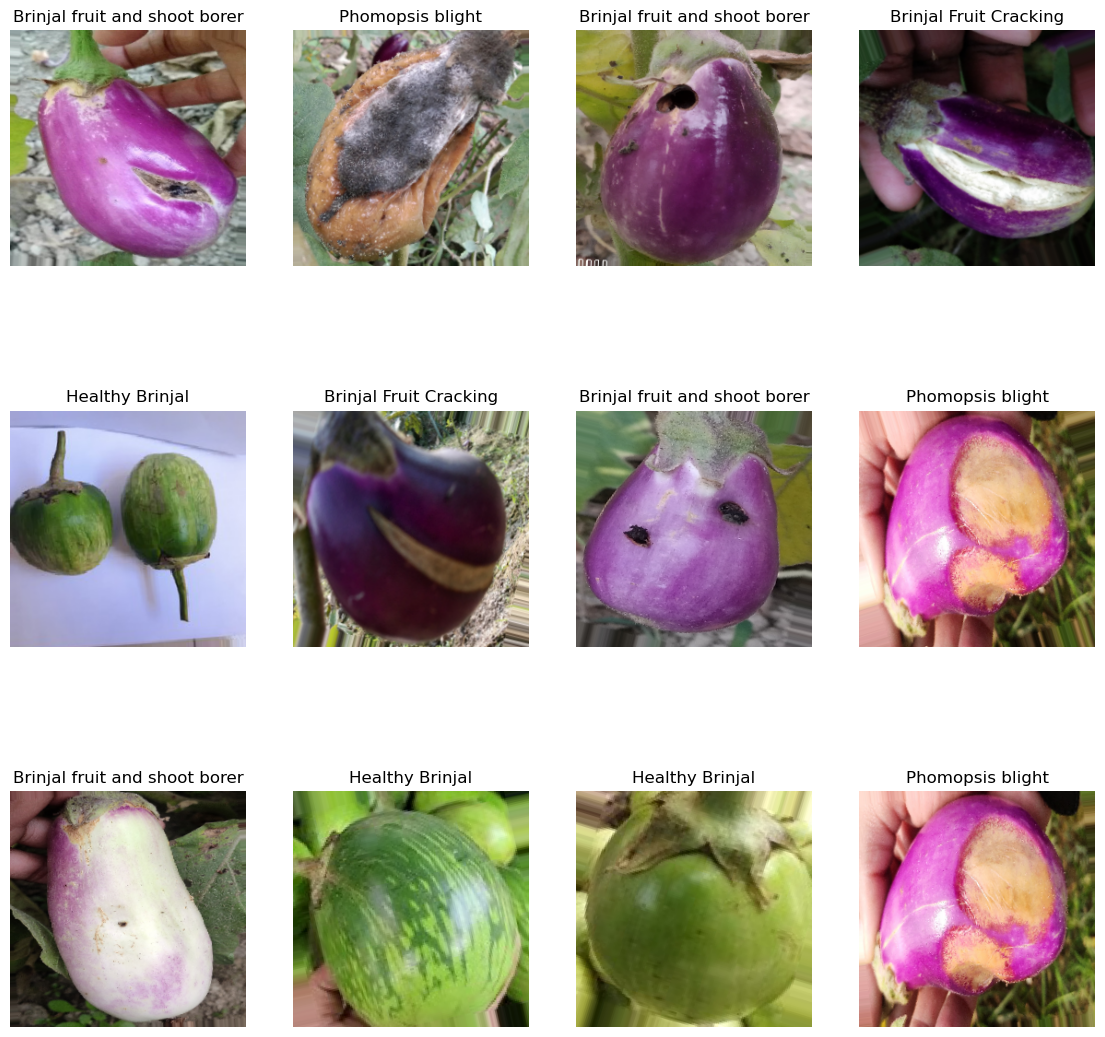

In [ ]:
plt.figure(figsize=(14, 14))
for image_batch, labels_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[labels_batch[i]])
        plt.axis("off")

## Train Test Split

In [ ]:
train_size = 0.7
len(dataset)*train_size

26.599999999999998

In [ ]:
train_ds = dataset.take(26)
len(train_ds)

26

In [ ]:
test_ds = dataset.skip(26)
len(test_ds)

12

In [ ]:
val_size=0.15
len(dataset)*val_size

5.7

In [ ]:
val_ds = test_ds.take(6)
len(val_ds)

6

In [ ]:
test_ds = test_ds.skip(6)
len(test_ds)

6

In [ ]:
#train data 70%, Test data 15%, Validation 15%
def get_dataset_partitions_tf(ds, train_split=0.7, val_split=0.15, test_split=0.15, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1

    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [ ]:
len(train_ds)

26

In [ ]:
len(val_ds)

5

In [ ]:
len(test_ds)

7

In [ ]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

## General Preprocess and Augmentation

In [ ]:
resize_and_rescale = tf.keras.Sequential([
  layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
  layers.experimental.preprocessing.Rescaling(1./255),
])

In [ ]:
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
])

In [ ]:
train_ds = train_ds.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

## Building The Model

## CNN Model

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model_01 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dense(n_classes, activation='softmax'),
])

model_01.build(input_shape=input_shape)

In [ ]:
model_01.summary()

Model: "sequential_8"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_118 (Conv2D)         (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_24 (MaxPoolin  (32, 127, 127, 32)       0         
 g2D)                                                            
                                                                 
 conv2d_119 (Conv2D)         (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_25 (MaxPoolin  (32, 62, 62, 64)         0         
 g2D)                                                            
                                                                 
 conv2d_120 (Conv2D)         (32, 60, 60, 128)        

In [ ]:
model_01.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_01 = model_01.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
26/26 [==============================] - 22s 810ms/step - loss: 1.5074 - accuracy: 0.4471 - val_loss: 1.2705 - val_accuracy: 0.6250
Epoch 2/25
26/26 [==============================] - 21s 821ms/step - loss: 0.8913 - accuracy: 0.7024 - val_loss: 0.6858 - val_accuracy: 0.7688
Epoch 3/25
26/26 [==============================] - 21s 804ms/step - loss: 0.7171 - accuracy: 0.7733 - val_loss: 0.6095 - val_accuracy: 0.7937
Epoch 4/25
26/26 [==============================] - 22s 830ms/step - loss: 0.6598 - accuracy: 0.7920 - val_loss: 0.6285 - val_accuracy: 0.7875
Epoch 5/25
26/26 [==============================] - 23s 866ms/step - loss: 0.5493 - accuracy: 0.8107 - val_loss: 0.4601 - val_accuracy: 0.8313
Epoch 6/25
26/26 [==============================] - 22s 860ms/step - loss: 0.4981 - accuracy: 0.8344 - val_loss: 0.4842 - val_accuracy: 0.8125
Epoch 7/25
26/26 [==============================] - 23s 865ms/step - loss: 0.4831 - accuracy: 0.8319 - val_loss: 0.4744 - val_accuracy: 0.8313

In [ ]:
scores_01 = model_01.evaluate(test_ds)

7/7 [==============================] - 1s 193ms/step - loss: 0.0949 - accuracy: 0.9777


## Plotting the Accuracy of CNN

In [ ]:
acc_01 = history_01.history['accuracy']
val_acc_01 = history_01.history['val_accuracy']

loss_01 = history_01.history['loss']
val_loss_01 = history_01.history['val_loss']

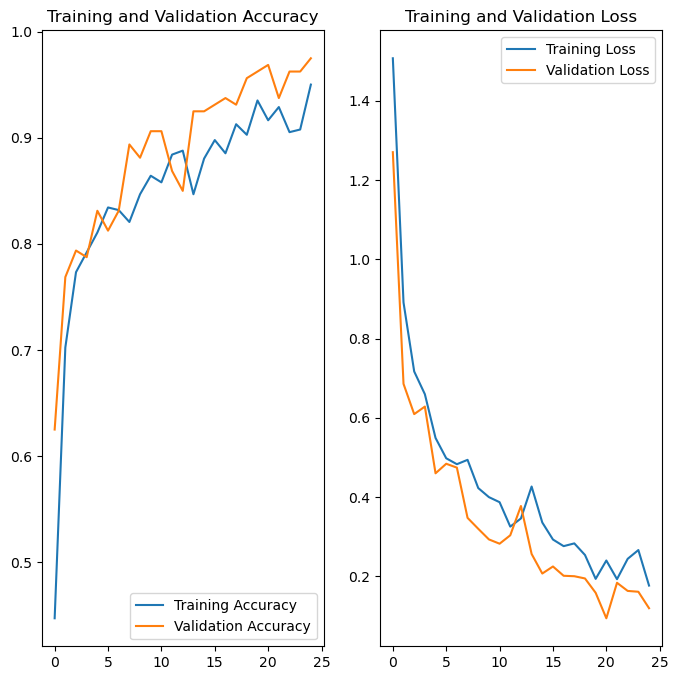

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_01, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_01, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_01, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_01, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cnn_acc_01=scores_01[1]*100
print(f"Test Accuracy: ",cnn_acc_01)

Test Accuracy:  97.76785969734192


## Resnet50 Model

In [ ]:
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.layers import Flatten
from keras.layers.core import Dense
from tensorflow.keras.optimizers import Adam

In [ ]:
model_04 = Sequential()

pretrained_model= tf.keras.applications.ResNet50(include_top=False,input_shape=(256,256,3),
                                                          pooling='avg',classes=4,
                                                          weights='imagenet')
for each_layer in pretrained_model.layers:
    each_layer.trainable=True

model_04.add(pretrained_model)


In [ ]:
model_04.add(Flatten())
model_04.add(Dense(512, activation='relu'))
model_04.add(Dense(4, activation='softmax'))

In [ ]:
model_04.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_4 (Dense)             (None, 512)               1049088   
                                                                 
 dense_5 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 24,585,732
Non-trainable params: 53,120
_________________________________________________________________


In [ ]:
model_04.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_04 = model_04.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=20,
)

Epoch 1/20
26/26 [==============================] - 121s 4s/step - loss: 0.8924 - accuracy: 0.7671 - val_loss: 56308.2070 - val_accuracy: 0.4313
Epoch 2/20
26/26 [==============================] - 125s 5s/step - loss: 0.6548 - accuracy: 0.8144 - val_loss: 9770.2637 - val_accuracy: 0.1937
Epoch 3/20
26/26 [==============================] - 131s 5s/step - loss: 0.4123 - accuracy: 0.8730 - val_loss: 175.4603 - val_accuracy: 0.1937
Epoch 4/20
26/26 [==============================] - 126s 5s/step - loss: 0.2721 - accuracy: 0.9153 - val_loss: 166.4924 - val_accuracy: 0.4375
Epoch 5/20
26/26 [==============================] - 123s 5s/step - loss: 0.2474 - accuracy: 0.9153 - val_loss: 23.2626 - val_accuracy: 0.5125
Epoch 6/20
26/26 [==============================] - 124s 5s/step - loss: 0.1609 - accuracy: 0.9452 - val_loss: 1.1619 - val_accuracy: 0.8188
Epoch 7/20
26/26 [==============================] - 125s 5s/step - loss: 0.1513 - accuracy: 0.9502 - val_loss: 19.8638 - val_accuracy: 0.3125


In [ ]:
scores_04 = model_04.evaluate(test_ds)

7/7 [==============================] - 9s 1s/step - loss: 0.1329 - accuracy: 0.9464


## Plotting the Accuracy of ResNet-50

In [ ]:
acc_04 = history_04.history['accuracy']
val_acc_04= history_04.history['val_accuracy']

loss_04 = history_04.history['loss']
val_loss_04 = history_04.history['val_loss']


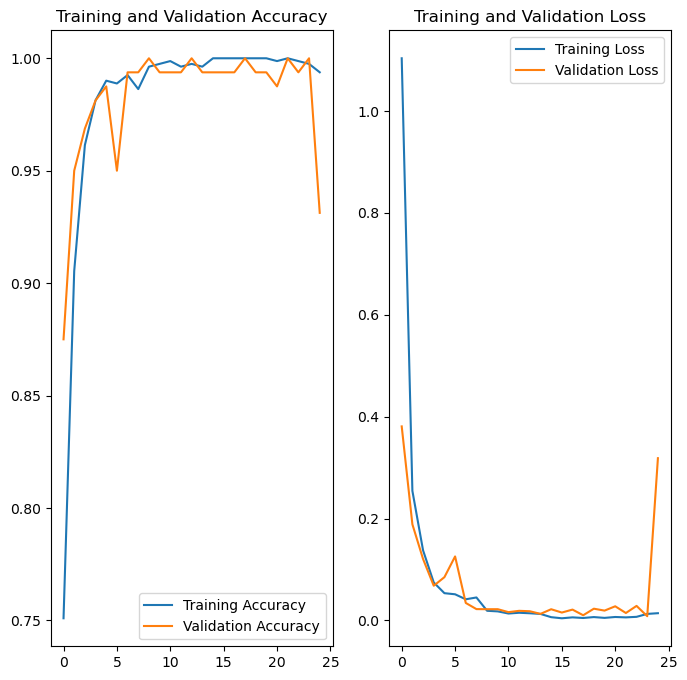

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_04, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_04, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_04, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_04, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
res_acc_04=scores_04[1]*100
print(f"Test Accuracy: ",res_acc_04)

Test Accuracy:  94.64285969734192


## InceptionV3 Model

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input

In [ ]:
InceptionV3_model = tf.keras.applications.InceptionV3(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
# The last 15 layers fine tune
for layer in InceptionV3_model.layers[:-15]:
    layer.trainable = False

x = InceptionV3_model.output
x = GlobalAveragePooling2D()(x)
x = Flatten()(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(units=512, activation='relu')(x)
x = Dropout(0.3)(x)

output  = Dense(units=4, activation='softmax')(x)
model_05 = Model(InceptionV3_model.input, output)


In [ ]:
model_05.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_24 (Conv2D)             (None, 127, 127, 32  864         ['input_2[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization_11 (BatchN  (None, 127, 127, 32  96         ['conv2d_24[0][0]']              
 ormalization)                  )                                                             

 conv2d_35 (Conv2D)             (None, 29, 29, 32)   6144        ['average_pooling2d[0][0]']      
                                                                                                  
 batch_normalization_16 (BatchN  (None, 29, 29, 64)  192         ['conv2d_29[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_18 (BatchN  (None, 29, 29, 64)  192         ['conv2d_31[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 batch_normalization_21 (BatchN  (None, 29, 29, 96)  288         ['conv2d_34[0][0]']              
 ormalization)                                                                                    
          

                                                                                                  
 conv2d_46 (Conv2D)             (None, 29, 29, 64)   18432       ['mixed1[0][0]']                 
                                                                                                  
 batch_normalization_33 (BatchN  (None, 29, 29, 64)  192         ['conv2d_46[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_22 (Activation)     (None, 29, 29, 64)   0           ['batch_normalization_33[0][0]'] 
                                                                                                  
 conv2d_44 (Conv2D)             (None, 29, 29, 48)   13824       ['mixed1[0][0]']                 
                                                                                                  
 conv2d_47

                                                                                                  
 activation_29 (Activation)     (None, 14, 14, 96)   0           ['batch_normalization_40[0][0]'] 
                                                                                                  
 max_pooling2d_22 (MaxPooling2D  (None, 14, 14, 288)  0          ['mixed2[0][0]']                 
 )                                                                                                
                                                                                                  
 mixed3 (Concatenate)           (None, 14, 14, 768)  0           ['activation_26[0][0]',          
                                                                  'activation_29[0][0]',          
                                                                  'max_pooling2d_22[0][0]']       
                                                                                                  
 conv2d_58

 mixed4 (Concatenate)           (None, 14, 14, 768)  0           ['activation_30[0][0]',          
                                                                  'activation_33[0][0]',          
                                                                  'activation_38[0][0]',          
                                                                  'activation_39[0][0]']          
                                                                                                  
 conv2d_68 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed4[0][0]']                 
                                                                                                  
 batch_normalization_55 (BatchN  (None, 14, 14, 160)  480        ['conv2d_68[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activatio

 conv2d_78 (Conv2D)             (None, 14, 14, 160)  122880      ['mixed5[0][0]']                 
                                                                                                  
 batch_normalization_65 (BatchN  (None, 14, 14, 160)  480        ['conv2d_78[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_54 (Activation)     (None, 14, 14, 160)  0           ['batch_normalization_65[0][0]'] 
                                                                                                  
 conv2d_79 (Conv2D)             (None, 14, 14, 160)  179200      ['activation_54[0][0]']          
                                                                                                  
 batch_normalization_66 (BatchN  (None, 14, 14, 160)  480        ['conv2d_79[0][0]']              
 ormalizat

 activation_64 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_75[0][0]'] 
                                                                                                  
 conv2d_89 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_64[0][0]']          
                                                                                                  
 batch_normalization_76 (BatchN  (None, 14, 14, 192)  576        ['conv2d_89[0][0]']              
 ormalization)                                                                                    
                                                                                                  
 activation_65 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_76[0][0]'] 
                                                                                                  
 conv2d_85 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed6[0][0]']                 
          

 ormalization)                                                                                    
                                                                                                  
 activation_73 (Activation)     (None, 14, 14, 192)  0           ['batch_normalization_84[0][0]'] 
                                                                                                  
 conv2d_94 (Conv2D)             (None, 14, 14, 192)  147456      ['mixed7[0][0]']                 
                                                                                                  
 conv2d_98 (Conv2D)             (None, 14, 14, 192)  258048      ['activation_73[0][0]']          
                                                                                                  
 batch_normalization_81 (BatchN  (None, 14, 14, 192)  576        ['conv2d_94[0][0]']              
 ormalization)                                                                                    
          

 ormalization)                                                                                    
                                                                                                  
 conv2d_108 (Conv2D)            (None, 6, 6, 192)    245760      ['average_pooling2d_7[0][0]']    
                                                                                                  
 batch_normalization_87 (BatchN  (None, 6, 6, 320)   960         ['conv2d_100[0][0]']             
 ormalization)                                                                                    
                                                                                                  
 activation_78 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_89[0][0]'] 
                                                                                                  
 activation_79 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_90[0][0]'] 
          

                                                                                                  
 activation_87 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_98[0][0]'] 
                                                                                                  
 activation_88 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_99[0][0]'] 
                                                                                                  
 activation_91 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_102[0][0]']
                                                                                                  
 activation_92 (Activation)     (None, 6, 6, 384)    0           ['batch_normalization_103[0][0]']
                                                                                                  
 batch_normalization_104 (Batch  (None, 6, 6, 192)   576         ['conv2d_117[0][0]']             
 Normaliza

In [ ]:
model_05.compile(optimizer=Adam(learning_rate=0.001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_05 = model_05.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=50,
)

Epoch 1/50
26/26 [==============================] - 28s 869ms/step - loss: 2.5885 - accuracy: 0.3885 - val_loss: 2.7290 - val_accuracy: 0.4750
Epoch 2/50
26/26 [==============================] - 22s 855ms/step - loss: 1.4641 - accuracy: 0.4384 - val_loss: 1.0510 - val_accuracy: 0.5688
Epoch 3/50
26/26 [==============================] - 23s 872ms/step - loss: 1.1330 - accuracy: 0.5442 - val_loss: 0.9590 - val_accuracy: 0.6000
Epoch 4/50
26/26 [==============================] - 23s 892ms/step - loss: 1.1892 - accuracy: 0.5131 - val_loss: 0.9830 - val_accuracy: 0.6062
Epoch 5/50
26/26 [==============================] - 25s 953ms/step - loss: 1.1208 - accuracy: 0.5467 - val_loss: 0.9831 - val_accuracy: 0.5562
Epoch 6/50
26/26 [==============================] - 25s 978ms/step - loss: 1.0268 - accuracy: 0.5878 - val_loss: 0.9243 - val_accuracy: 0.6500
Epoch 7/50
26/26 [==============================] - 26s 996ms/step - loss: 0.9914 - accuracy: 0.6252 - val_loss: 0.8368 - val_accuracy: 0.6625

In [ ]:
scores_05 = model_05.evaluate(test_ds)

7/7 [==============================] - 6s 806ms/step - loss: 0.4515 - accuracy: 0.8393


## Plotting the Accuracy of InceptionV3

In [ ]:
acc_05 = history_05.history['accuracy']
val_acc_05 = history_05.history['val_accuracy']

loss_05 = history_05.history['loss']
val_loss_05 = history_05.history['val_loss']

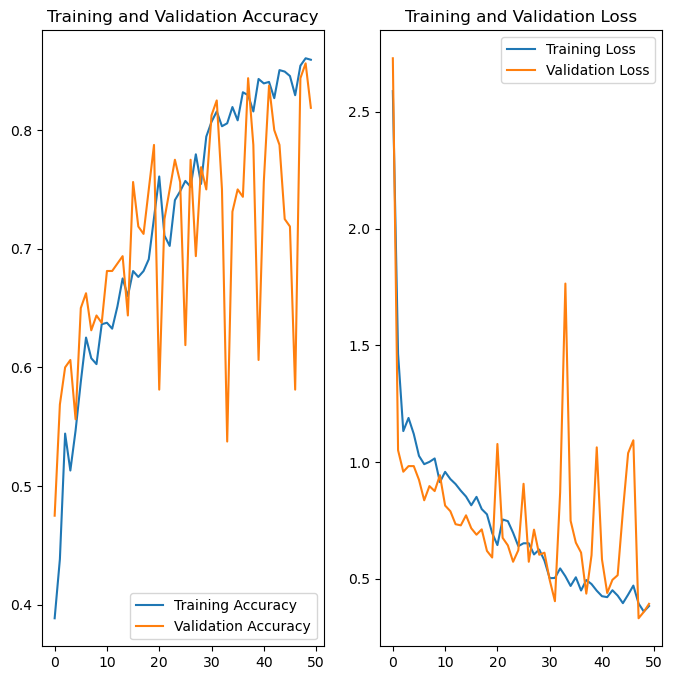

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(50), acc_05, label='Training Accuracy')
plt.plot(range(50), val_acc_05, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(50), loss_05, label='Training Loss')
plt.plot(range(50), val_loss_05, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
inc_acc_05=scores_05[1]*100
print(f"Test Accuracy: ",inc_acc_05)

Test Accuracy:  83.92857313156128


## CNN Model Architecture: 02

In [ ]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 4

model_02 = models.Sequential([
    resize_and_rescale,
    layers.Conv2D(32, kernel_size = (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(64,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(128,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Conv2D(256,  kernel_size = (3,3), activation='relu'),
    layers.MaxPooling2D((2, 2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(512, activation='relu'),
    layers.Dropout(0.50),
    layers.BatchNormalization(),

    layers.Dense(n_classes, activation='softmax'),
])

model_02.build(input_shape=input_shape)

In [ ]:
model_02.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_8 (Conv2D)           (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_8 (MaxPooling  (32, 127, 127, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_5 (Batc  (32, 127, 127, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_9 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_9 (MaxPooling  (32, 62, 62, 64)        

In [ ]:
model_02.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [ ]:
history_02 = model_02.fit(
    train_ds,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    verbose=1,
    epochs=EPOCHS,
)

Epoch 1/25
26/26 [==============================] - 25s 941ms/step - loss: 1.1065 - accuracy: 0.7111 - val_loss: 1.8281 - val_accuracy: 0.4313
Epoch 2/25
26/26 [==============================] - 21s 820ms/step - loss: 0.4948 - accuracy: 0.8306 - val_loss: 2.1570 - val_accuracy: 0.4313
Epoch 3/25
26/26 [==============================] - 22s 838ms/step - loss: 0.6848 - accuracy: 0.7821 - val_loss: 1.3548 - val_accuracy: 0.4688
Epoch 4/25
26/26 [==============================] - 22s 858ms/step - loss: 0.5367 - accuracy: 0.8232 - val_loss: 1.5148 - val_accuracy: 0.4563
Epoch 5/25
26/26 [==============================] - 23s 891ms/step - loss: 0.4655 - accuracy: 0.8381 - val_loss: 1.8207 - val_accuracy: 0.5312
Epoch 6/25
26/26 [==============================] - 24s 911ms/step - loss: 0.3313 - accuracy: 0.8829 - val_loss: 2.6838 - val_accuracy: 0.5375
Epoch 7/25
26/26 [==============================] - 24s 914ms/step - loss: 0.3104 - accuracy: 0.8817 - val_loss: 3.0024 - val_accuracy: 0.5500

In [ ]:
scores_02 = model_02.evaluate(test_ds)

7/7 [==============================] - 1s 202ms/step - loss: 0.1359 - accuracy: 0.9821


## Plotting the Accuracy of Model 02

In [ ]:
acc_02 = history_02.history['accuracy']
val_acc_02= history_02.history['val_accuracy']

loss_02 = history_02.history['loss']
val_loss_02 = history_02.history['val_loss']


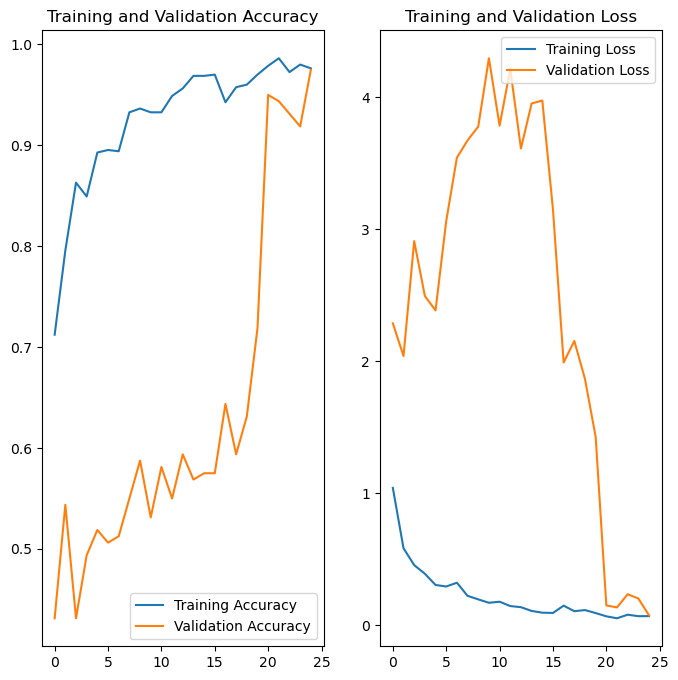

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc_02, label='Training Accuracy')
plt.plot(range(EPOCHS), val_acc_02, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss_02, label='Training Loss')
plt.plot(range(EPOCHS), val_loss_02, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
cnn_acc_02=scores_02[1]*100
print(f"Test Accuracy: ",cnn_acc_02)

Test Accuracy:  98.21428656578064


## EfficientNetB4


In [ ]:
from tensorflow.keras.applications import EfficientNetB4
from tensorflow.keras.optimizers import Adam

In [ ]:
efficientNetB4_model = tf.keras.applications.EfficientNetB4(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

In [ ]:
efficientNetB4_model.trainable = False

# Setup model architecture with trainable top layers
inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS), name="input_layer")
x = data_augmentation(inputs)

x = efficientNetB4_model(x, training=False)
x = layers.GlobalAveragePooling2D(name="global_avg_pool_layer")(x)



outputs = layers.Dense(4, activation="softmax", name="output_layer")(x)
model_06 = tf.keras.Model(inputs, outputs)

In [ ]:
model_06.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 256, 256, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 256, 256, 3)       0         
                                                                 
 efficientnetb4 (Functional)  (None, 8, 8, 1792)       17673823  
                                                                 
 global_avg_pool_layer (Glob  (None, 1792)             0         
 alAveragePooling2D)                                             
                                                                 
 output_layer (Dense)        (None, 4)                 7172      
                                                                 
Total params: 17,680,995
Trainable params: 7,172
Non-trainable params: 17,673,823
___________________________________________

In [ ]:
model_06.compile(optimizer=Adam(learning_rate=0.00001),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [ ]:
history_06 = model_06.fit(
    train_ds,
    validation_data=val_ds,
    verbose=1,
    epochs=75,
)

Epoch 1/75
26/26 [==============================] - 61s 2s/step - loss: 1.4192 - accuracy: 0.2391 - val_loss: 1.4132 - val_accuracy: 0.2313
Epoch 2/75
26/26 [==============================] - 44s 2s/step - loss: 1.3920 - accuracy: 0.2428 - val_loss: 1.3903 - val_accuracy: 0.2625
Epoch 3/75
26/26 [==============================] - 46s 2s/step - loss: 1.3658 - accuracy: 0.2889 - val_loss: 1.3684 - val_accuracy: 0.2812
Epoch 4/75
26/26 [==============================] - 45s 2s/step - loss: 1.3522 - accuracy: 0.3250 - val_loss: 1.3472 - val_accuracy: 0.3125
Epoch 5/75
26/26 [==============================] - 46s 2s/step - loss: 1.3162 - accuracy: 0.3611 - val_loss: 1.3268 - val_accuracy: 0.3562
Epoch 6/75
26/26 [==============================] - 49s 2s/step - loss: 1.2920 - accuracy: 0.4222 - val_loss: 1.3071 - val_accuracy: 0.3562
Epoch 7/75
26/26 [==============================] - 47s 2s/step - loss: 1.2731 - accuracy: 0.4508 - val_loss: 1.2888 - val_accuracy: 0.3938
Epoch 8/75
26/26 [==

In [ ]:
scores_06 = model_06.evaluate(test_ds)

7/7 [==============================] - 10s 1s/step - loss: 0.6399 - accuracy: 0.8080


## Plotting the Accuracy of EfficientNetB4


In [ ]:
acc_06 = history_06.history['accuracy']
val_acc_06= history_06.history['val_accuracy']

loss_06 = history_06.history['loss']
val_loss_06 = history_06.history['val_loss']

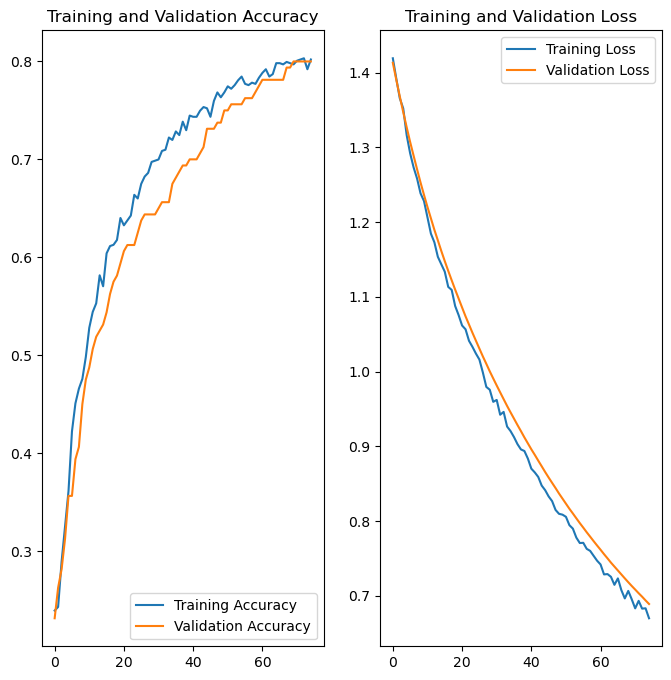

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(range(75), acc_06, label='Training Accuracy')
plt.plot(range(75), val_acc_06, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(75), loss_06, label='Training Loss')
plt.plot(range(75), val_loss_06, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
efn_acc_06=scores_06[1]*100
print(f"Test Accuracy: ",efn_acc_06)

Test Accuracy:  80.80357313156128


##  Run Prediction With CNN Architecture -02 on a sample image

first image to predict
actual label: Brinjal fruit and shoot borer
1/1 [==============================] - 0s 253ms/step
predicted label: Brinjal fruit and shoot borer


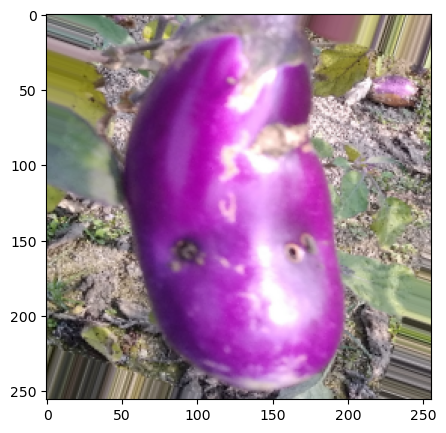

In [ ]:
import numpy as np
for images_batch, labels_batch in test_ds.take(1):

    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()

    print("first image to predict")
    plt.imshow(first_image)
    print("actual label:",class_names[first_label])

    batch_prediction = model_02.predict(images_batch)
    print("predicted label:",class_names[np.argmax(batch_prediction[0])])

In [ ]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0)

    predictions = model_02.predict(img_array)

    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


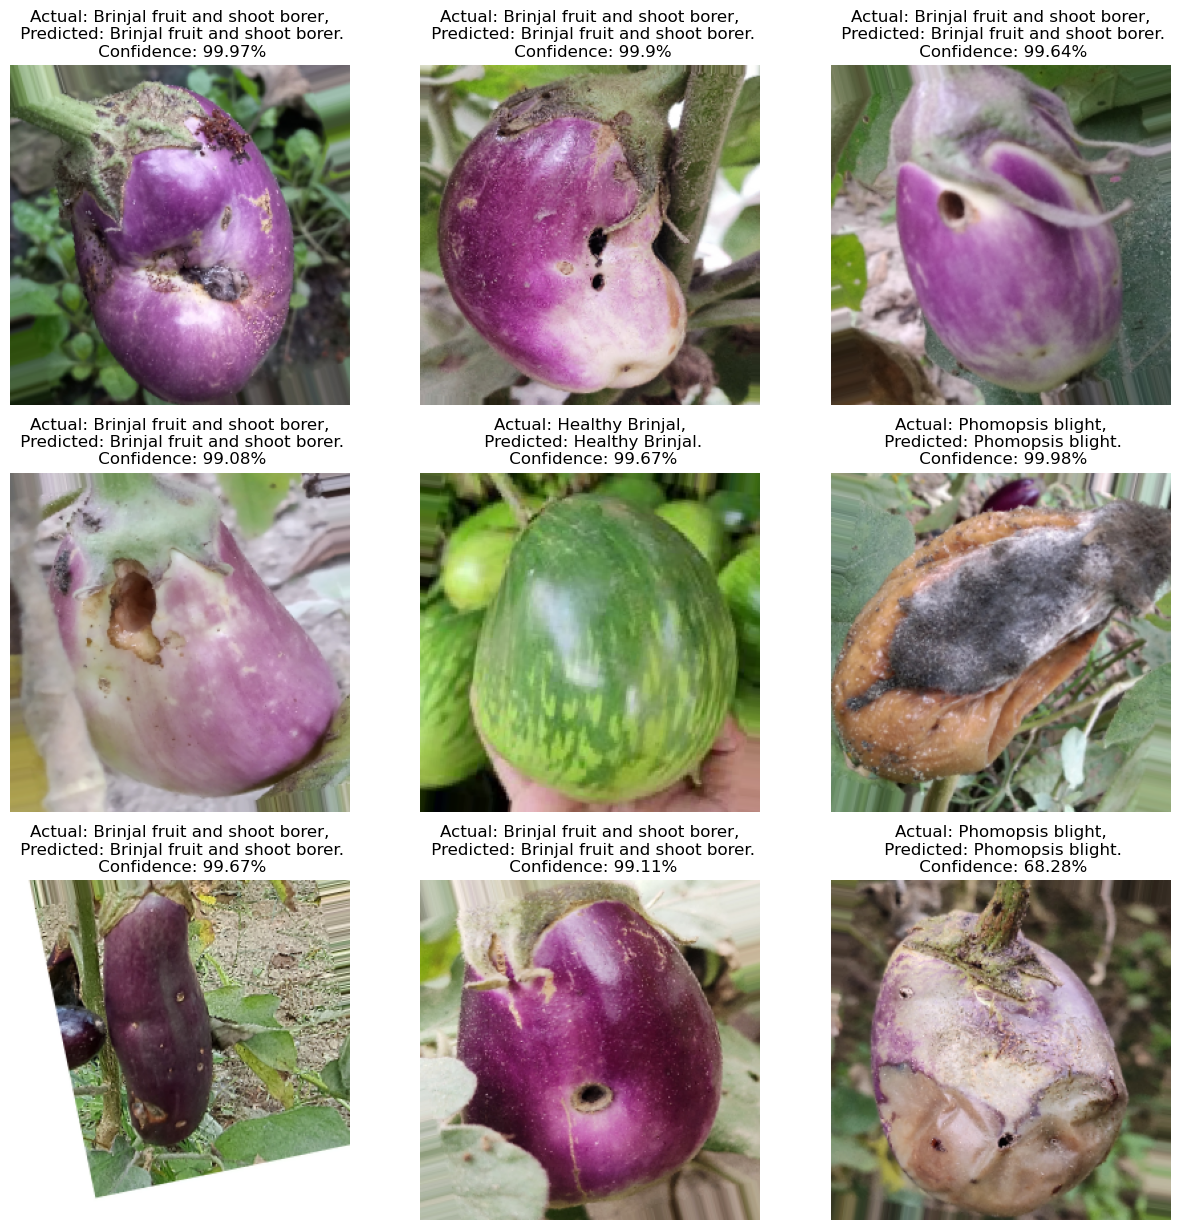

In [ ]:
plt.figure(figsize=(15, 15))
for images, labels in test_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model_02, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}%")

        plt.axis("off")


## Confusion Metrix


In [ ]:
def plot_confusion_matrix(cm, classes,
                        normalize=False,
                        title='Confusion matrix',
                        cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [ ]:
def labels(model,dataset):
    y_pred = []  # store predicted labels
    y_true = []  # store true labels

    # iterate over the dataset
    for image_batch, label_batch in dataset:   # use dataset.unbatch() with repeat
       # append true labels
       y_true.append(label_batch)
       # compute predictions
       preds = model.predict(image_batch)
       # append predicted labels
       y_pred.append(np.argmax(preds, axis = - 1))

    # convert the true and predicted labels into tensors
    correct_labels = tf.concat([item for item in y_true], axis = 0)
    predicted_labels = tf.concat([item for item in y_pred], axis = 0)
    return correct_labels , predicted_labels

## Confusion metrix of ResNet-50

1/1 [==============================] - 1s 1s/step
Confusion matrix, without normalization
[[22  1  0  2]
 [ 1 85  7  0]
 [ 0  0 65  0]
 [ 0  1  0 40]]


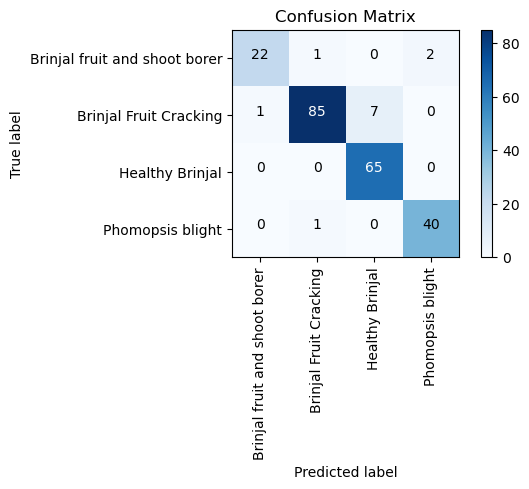

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels = ['Brinjal fruit and shoot borer','Brinjal Fruit Cracking','Healthy Brinjal','Phomopsis blight']
y_true,y_pred=labels(model_04,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')


In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))


              precision    recall  f1-score   support

           0       1.00      0.96      0.98        25
           1       0.99      0.91      0.95        93
           2       0.92      1.00      0.96        65
           3       0.95      1.00      0.98        41

    accuracy                           0.96       224
   macro avg       0.96      0.97      0.97       224
weighted avg       0.96      0.96      0.96       224



## Confusion Matrix of InceptionV3


1/1 [==============================] - 0s 405ms/step
Confusion matrix, without normalization
[[ 8 13  0  4]
 [ 0 88  4  1]
 [ 0  8 57  0]
 [ 2  1  0 38]]


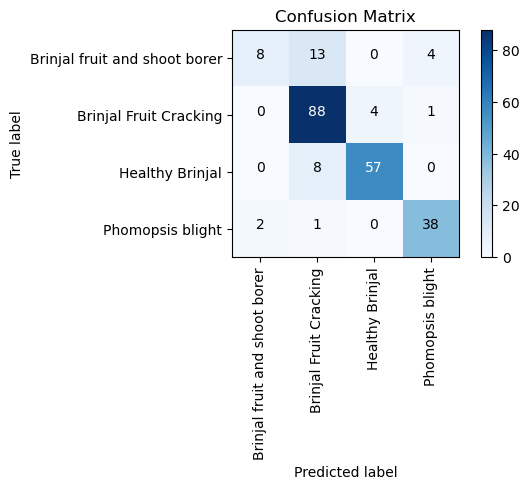

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels = ['Brinjal fruit and shoot borer','Brinjal Fruit Cracking','Healthy Brinjal','Phomopsis blight']
y_true,y_pred=labels(model_05,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.80      0.32      0.46        25
           1       0.80      0.95      0.87        93
           2       0.93      0.88      0.90        65
           3       0.88      0.93      0.90        41

    accuracy                           0.85       224
   macro avg       0.85      0.77      0.78       224
weighted avg       0.85      0.85      0.84       224



## Confusion Matrix of CNN

1/1 [==============================] - 0s 182ms/step
Confusion matrix, without normalization
[[24  1  0  0]
 [ 0 92  1  0]
 [ 0  2 63  0]
 [ 1  0  0 40]]


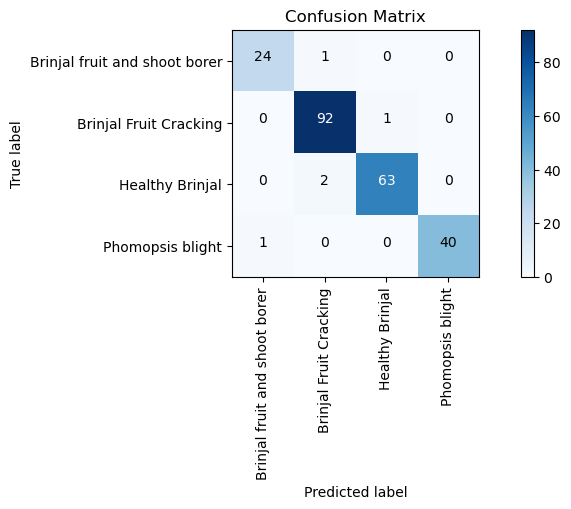

In [ ]:
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
cm_plot_labels = ['Brinjal fruit and shoot borer','Brinjal Fruit Cracking','Healthy Brinjal','Phomopsis blight']
y_true,y_pred=labels(model_01,test_ds)#changing line
cm = confusion_matrix(y_true=y_true, y_pred=y_pred)
plot_confusion_matrix(cm=cm, classes=cm_plot_labels, title='Confusion Matrix')

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        25
           1       0.97      0.99      0.98        93
           2       0.98      0.97      0.98        65
           3       1.00      0.98      0.99        41

    accuracy                           0.98       224
   macro avg       0.98      0.97      0.98       224
weighted avg       0.98      0.98      0.98       224

